In [1]:
from eeg_lib.data.data_setup import TripletEEGDataset
from eeg_lib.data.data_loader.EEGDataExtractor import EEGDataExtractor
from eeg_lib.models.verification.EEGNet import EEGNetEmbeddingModel
from eeg_lib.commons.constant import DATASETS_FOLDER

from sklearn.model_selection import train_test_split

In [ ]:
DATA_DIR = f"{DATASETS_FOLDER}/Kolory/"

extractor = EEGDataExtractor(data_dir=DATA_DIR)
eeg_df, participants = extractor.extract_dataframe()

In [3]:
eeg_df.head()

,participant_id,epoch,label
0,46607ce4@1717,"[[-9.24481589731569e-06, -9.598635937503012e-0...",gray
1,46607ce4@1717,"[[-2.0148758591275883e-06, -1.1913500968321893...",green
2,46607ce4@1717,"[[-1.7344745961061525e-07, 1.012701607648391e-...",gray
3,46607ce4@1717,"[[4.047473978354836e-06, 2.417326642595136e-06...",blue
4,46607ce4@1717,"[[-8.859812648227801e-06, -1.0092267325555332e...",gray


In [4]:
print(eeg_df.columns)

Index(['participant_id', 'epoch', 'label'], dtype='object')


In [5]:
unique_participants = eeg_df["participant_id"].unique()

train_participants, test_participants = train_test_split(
    unique_participants, test_size=0.2, random_state=0
)

train_df = eeg_df[eeg_df["participant_id"].isin(train_participants)].reset_index(
    drop=True
)
test_df = eeg_df[eeg_df["participant_id"].isin(test_participants)].reset_index(
    drop=True
)

print("Training set participants:", train_participants)
print("Test set participants:", test_participants)

Training set participants: ['446b3735@1618' '022e8467@1910' '6e542bc2@0845' '548fd734@1628'
 '90441f44@1643' 'e283301e@1606' '39285860@1825' '3033b74a@1626'
 '6d9a8b86@1613' '8bd3032e@1746' 'bf2d2193@1638' 'e08138e2@1731'
 '25d0bdb3@1318' '51ec2c20@0923' '2882ae26@1441' '06f240e9@1215'
 '36eea4bb@1519' 'f82b5699@1757' 'fd8a3308@1135' 'e43a9f9f@0941'
 '46607ce4@1717' 'b34b1427@0906' '2718372d@1400' '8dca0725@1418']
Test set participants: ['9e8bae0e@1828' 'd87e1bd3@1806' 'ffae50df@1712' '54e60118@1339'
 '011595b1@1651' '541c91f2@1456']


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

triplet_train_dataset = TripletEEGDataset(train_df)
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=8, shuffle=True)

model = EEGNetEmbeddingModel(
    num_channels=4, num_time_points=751, num_classes=0, embedding_dimension=32
)

import torch.nn.functional as F

triplet_loss_fn = nn.TripletMarginLoss(margin=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for anchor, positive, negative in triplet_train_loader:
        anchor_embedding, _ = model(anchor)
        pos_embedding, _ = model(positive)
        neg_embedding, _ = model(negative)

        anchor_embedding = F.normalize(anchor_embedding, p=2, dim=1)
        pos_embedding = F.normalize(pos_embedding, p=2, dim=1)
        neg_embedding = F.normalize(neg_embedding, p=2, dim=1)

        loss = triplet_loss_fn(anchor_embedding, pos_embedding, neg_embedding)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(triplet_train_loader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1037.)
  return F.conv2d(


Epoch 1, Average Loss: 0.0872
Epoch 2, Average Loss: 0.0561
Epoch 3, Average Loss: 0.0509
Epoch 4, Average Loss: 0.0494
Epoch 5, Average Loss: 0.0481
Epoch 6, Average Loss: 0.0461
Epoch 7, Average Loss: 0.0465
Epoch 8, Average Loss: 0.0448
Epoch 9, Average Loss: 0.0442
Epoch 10, Average Loss: 0.0429
Epoch 11, Average Loss: 0.0357
Epoch 12, Average Loss: 0.0300
Epoch 13, Average Loss: 0.0258
Epoch 14, Average Loss: 0.0216
Epoch 15, Average Loss: 0.0200
Epoch 16, Average Loss: 0.0199
Epoch 17, Average Loss: 0.0180
Epoch 18, Average Loss: 0.0186
Epoch 19, Average Loss: 0.0178
Epoch 20, Average Loss: 0.0176
Epoch 21, Average Loss: 0.0177
Epoch 22, Average Loss: 0.0179
Epoch 23, Average Loss: 0.0173
Epoch 24, Average Loss: 0.0169
Epoch 25, Average Loss: 0.0170
Epoch 26, Average Loss: 0.0159
Epoch 27, Average Loss: 0.0163
Epoch 28, Average Loss: 0.0162
Epoch 29, Average Loss: 0.0158
Epoch 30, Average Loss: 0.0157
Epoch 31, Average Loss: 0.0162
Epoch 32, Average Loss: 0.0159
Epoch 33, Average

In [7]:
import numpy as np

model.eval()
embeddings_list = []
participant_ids_list = []

with torch.no_grad():
    for i, row in test_df.iterrows():
        # Each row's epoch is of shape (4, 751); add channel dim → (1,4,751)
        data = torch.tensor(row["epoch"], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        embedding, _ = model(data)
        embedding = F.normalize(
            embedding, p=2, dim=1
        )  # normalize for similarity metrics
        embeddingeddings_list.append(embedding.squeeze(0).cpu().numpy())
        participant_ids_list.append(row["participant_id"])

embeddings_array = np.stack(embeddings_list)  # (N, 32)
participant_ids_array = np.array(participant_ids_list)

In [8]:
from collections import defaultdict

user_profiles = defaultdict(list)
for embedding, pid in zip(embeddings_array, participant_ids_array):
    user_profiles[pid].append(embedding)

for pid in user_profiles:
    user_profiles[pid] = np.mean(user_profiles[pid], axis=0)

In [9]:
def verify_sample(new_embedding, user_profile, threshold):
    distance = np.linalg.norm(new_embedding - user_profile)
    return distance < threshold, distance


sample_data = (
    torch.tensor(test_df.iloc[0]["epoch"], dtype=torch.float32)
    .unsqueeze(0)
    .unsqueeze(0)
)
with torch.no_grad():
    sample_embedding, _ = model(sample_data)
    sample_embedding = (
        F.normalize(sample_embedding, p=2, dim=1).squeeze(0).cpu().numpy()
    )

user_id = test_df.iloc[0]["participant_id"]
user_profile = user_profiles[user_id]

accepted, distance = verify_sample(sample_embedding, user_profile, threshold=0.5)
print(
    f"Verification result: {'Accepted' if accepted else 'Rejected'}, Distance: {distance:.4f}"
)

Verification result: Accepted, Distance: 0.1115


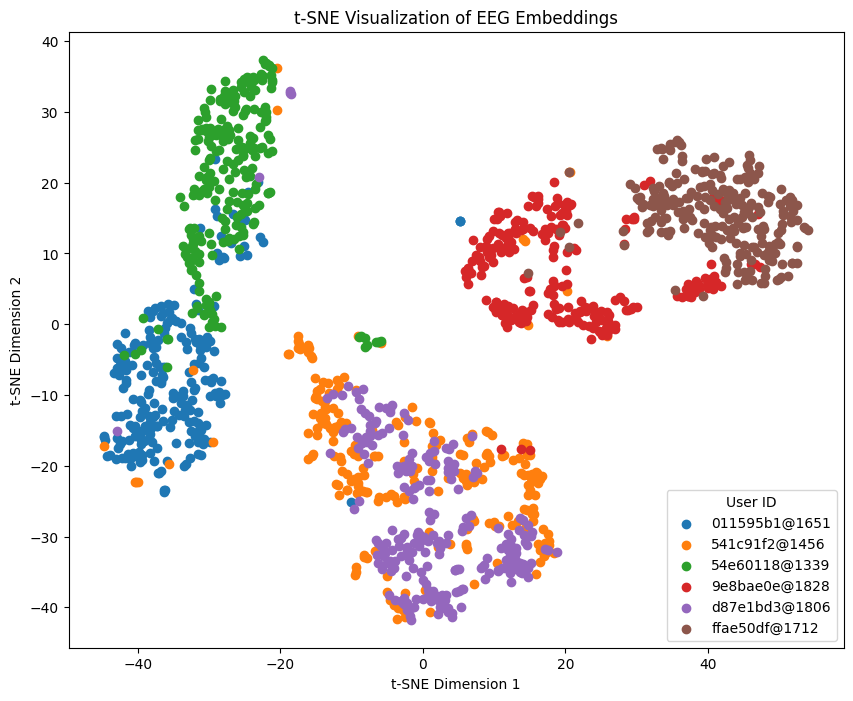

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(10, 8))
unique_users = np.unique(participant_ids_array)
for uid in unique_users:
    indices = np.where(participant_ids_array == uid)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=str(uid))
plt.legend(title="User ID")
plt.title("t-SNE Visualization of EEG Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

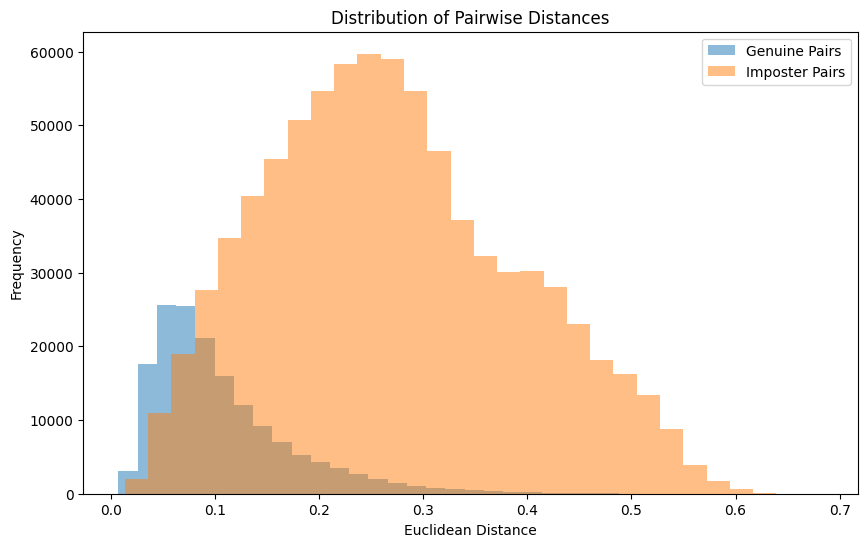

In [11]:
genuine_distances = []
imposter_distances = []

N = len(embeddings_array)
for i in range(N):
    for j in range(i + 1, N):
        distance = np.linalg.norm(embeddings_array[i] - embeddings_array[j])
        if participant_ids_array[i] == participant_ids_array[j]:
            genuine_distances.append(distance)
        else:
            imposter_distances.append(distance)

plt.figure(figsize=(10, 6))
plt.hist(genuine_distances, bins=30, alpha=0.5, label="Genuine Pairs")
plt.hist(imposter_distances, bins=30, alpha=0.5, label="Imposter Pairs")
plt.title("Distribution of Pairwise Distances")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Note: you may need to restart the kernel to use updated packages.


/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


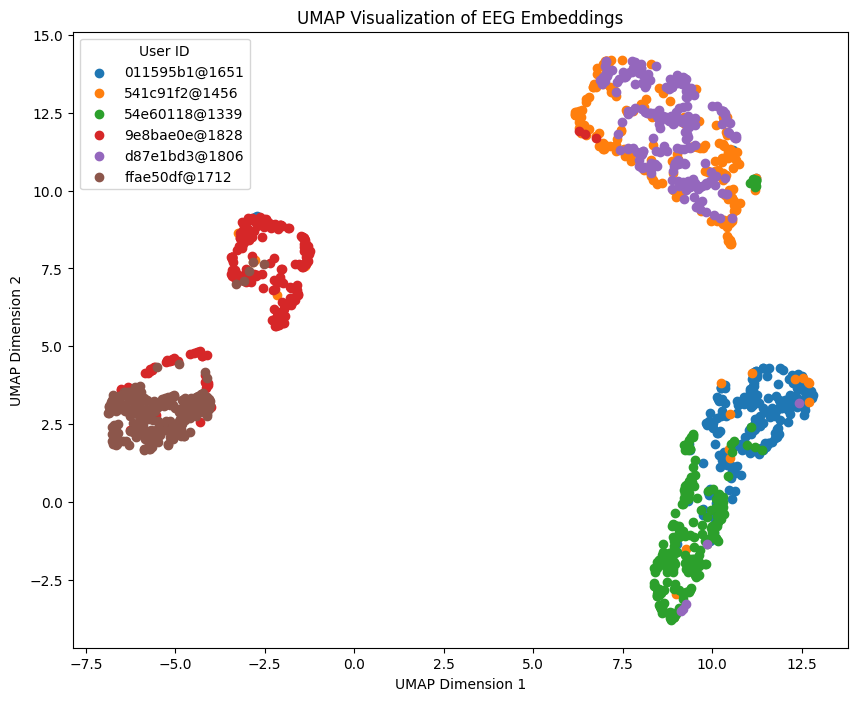

In [12]:
%pip install umap-learn

import umap
import matplotlib.pyplot as plt


reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

umap_coords = reducer.fit_transform(embeddings_array)


plt.figure(figsize=(10, 8))
unique_users = np.unique(participant_ids_array)
for user in unique_users:
    indices = np.where(participant_ids_array == user)
    plt.scatter(umap_coords[indices, 0], umap_coords[indices, 1], label=str(user))

plt.legend(title="User ID")
plt.title("UMAP Visualization of EEG Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()